# Wasserstein Loss based Conditional Self-Attention GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
Same as Wasserstein Loss based Self-Attention GAN, except we also pass in labels to the generator and discriminator.

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import SelfAttention, FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, clean_make_dir, save_best_generator_image, mean_fid

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class CSAWGenerator(tnn.Module):
    def __init__(self, latent_size=100, num_classes=10, hidden_units=64):
        super(CSAWGenerator, self).__init__()
        self.attn_layer = SelfAttention(hidden_units)
        self.l1_1 = tnn.Sequential(
            # Input layer for images
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(latent_size, out_channels=hidden_units * 4, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
        )
        self.l1_2 = tnn.Sequential(
            # Input layer for labels
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(num_classes, out_channels=hidden_units * 4, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
        )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 8, hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
        )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 4, hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 2),
            tnn.ReLU(True)
        )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 2, hidden_units, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units),
            tnn.ReLU(True)
        )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
        )
        return

    def forward(self, x, y):
        x = self.l1_1(x)
        y = self.l1_2(y)
        output = t.cat((x, y), dim=1)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.attn_layer(output)
        output = self.lout(output)
        return output

class CSAWDiscriminator(tnn.Module):
    def __init__(self, num_classes=10, hidden_units=64):
        super(CSAWDiscriminator, self).__init__()
        self.num_hidden_units = hidden_units
        self.attn_layer = SelfAttention(hidden_units)
        self.l1_1 = tnn.Sequential(
            # Input layer for images
            tnn.utils.spectral_norm(tnn.Conv2d(in_channels=3, out_channels=hidden_units // 2, kernel_size=4, stride=2, padding=1, bias=False)),
            tnn.LeakyReLU(0.2, inplace=True)
        )
        self.l1_2 = tnn.Sequential(
            # Input layer for labels
            tnn.utils.spectral_norm(tnn.Conv2d(in_channels=num_classes, out_channels=hidden_units // 2, kernel_size=4, stride=2, padding=1, bias=False)),
            tnn.LeakyReLU(0.2, inplace=True)
        )
        self.l2 = tnn.Sequential(
            # Layer 1
            tnn.utils.spectral_norm(tnn.Conv2d(hidden_units, hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 2),
            tnn.LeakyReLU(0.2, inplace=True)
        )
        self.l3 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.Conv2d(hidden_units * 2, hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.LeakyReLU(0.2, inplace=True),
        )
        self.l4 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.Conv2d(hidden_units * 4, hidden_units * 8, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 8),
            tnn.LeakyReLU(0.2, inplace=True),
        )
        self.lout = tnn.Sequential(
            # Output Layer
            tnn.Linear(4 * 4 * 4 * hidden_units, 1, bias=False)
        )
        return

    def forward(self, x, y):
        x = self.l1_1(x)
        y = self.l1_2(y)
        output = t.cat((x, y), dim=1)
        output = self.attn_layer(output)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = output.view(-1, 4 * 4 * 4 * self.num_hidden_units)
        output = self.lout(output)
        return output

### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/csawgan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 50
gen_hidden_units = 32
dis_hidden_units = 32
debug_info       = False
clean_dirs       = True
save_best        = True
critic_iters     = 5
log_interval     = 100
fid_batch_interval = 10

### Actual Model Run

21/10/2019 05:04:03 PM - INFO: Clean selected - removing: ./output/csawgan
21/10/2019 05:04:03 PM - INFO: Creating output directory: ./output/csawgan
21/10/2019 05:04:03 PM - INFO: Dataset path: ./cifar10, Output path: ./output/csawgan, Batch Size: 32, Latent Size: 100, Num iterations: 50, Generator unit multiplier: 32, Discriminator unit multiplier: 32, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


21/10/2019 05:04:04 PM - INFO: CUDA enabled device found - will use CUDA device
21/10/2019 05:04:09 PM - INFO: CSAWGenerator(
  (attn_layer): SelfAttention(
    (conv_query): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_key): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_value): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (l1_1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1_2): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, mo

21/10/2019 05:11:03 PM - INFO: Epoch: 4/50, Sample: 101/1562, Disc Loss: -0.2938, Gen Loss: 0.1230
21/10/2019 05:11:06 PM - INFO: Epoch: 4/50, Sample: 201/1562, Disc Loss: -0.1797, Gen Loss: 0.1238
21/10/2019 05:11:09 PM - INFO: Epoch: 4/50, Sample: 301/1562, Disc Loss: -0.1926, Gen Loss: -0.0812
21/10/2019 05:11:12 PM - INFO: Epoch: 4/50, Sample: 401/1562, Disc Loss: -0.1661, Gen Loss: 0.1495
21/10/2019 05:11:16 PM - INFO: Epoch: 4/50, Sample: 501/1562, Disc Loss: -0.1035, Gen Loss: 0.1418
21/10/2019 05:11:19 PM - INFO: Epoch: 4/50, Sample: 601/1562, Disc Loss: -0.1447, Gen Loss: 0.0250
21/10/2019 05:11:22 PM - INFO: Epoch: 4/50, Sample: 701/1562, Disc Loss: -0.1455, Gen Loss: 0.1292
21/10/2019 05:11:25 PM - INFO: Epoch: 4/50, Sample: 801/1562, Disc Loss: -0.1783, Gen Loss: 0.0477
21/10/2019 05:11:29 PM - INFO: Epoch: 4/50, Sample: 901/1562, Disc Loss: -0.1902, Gen Loss: 0.1466
21/10/2019 05:11:32 PM - INFO: Epoch: 4/50, Sample: 1001/1562, Disc Loss: -0.1820, Gen Loss: 0.0787
21/10/20

21/10/2019 05:22:22 PM - INFO: Epoch: 9/50, Sample: 1/1562, Disc Loss: -0.0610, Gen Loss: 0.0776
21/10/2019 05:22:25 PM - INFO: Epoch: 9/50, Sample: 101/1562, Disc Loss: -0.0695, Gen Loss: -0.0171
21/10/2019 05:22:28 PM - INFO: Epoch: 9/50, Sample: 201/1562, Disc Loss: -0.0723, Gen Loss: -0.0596
21/10/2019 05:22:31 PM - INFO: Epoch: 9/50, Sample: 301/1562, Disc Loss: -0.0756, Gen Loss: -0.0497
21/10/2019 05:22:35 PM - INFO: Epoch: 9/50, Sample: 401/1562, Disc Loss: -0.2444, Gen Loss: 0.1533
21/10/2019 05:22:38 PM - INFO: Epoch: 9/50, Sample: 501/1562, Disc Loss: -0.0687, Gen Loss: 0.0938
21/10/2019 05:22:41 PM - INFO: Epoch: 9/50, Sample: 601/1562, Disc Loss: -0.0743, Gen Loss: 0.0117
21/10/2019 05:22:44 PM - INFO: Epoch: 9/50, Sample: 701/1562, Disc Loss: -0.1476, Gen Loss: 0.1425
21/10/2019 05:22:48 PM - INFO: Epoch: 9/50, Sample: 801/1562, Disc Loss: -0.0462, Gen Loss: 0.0428
21/10/2019 05:22:51 PM - INFO: Epoch: 9/50, Sample: 901/1562, Disc Loss: -0.1489, Gen Loss: -0.0081
21/10/20

21/10/2019 05:32:22 PM - INFO: Epoch: 13/50, Sample: 1501/1562, Disc Loss: -0.0763, Gen Loss: 0.0131
21/10/2019 05:33:51 PM - INFO: Epoch 13 FID score: 136.50337800272604
21/10/2019 05:33:51 PM - INFO: Epoch: 14/50, Sample: 1/1562, Disc Loss: -0.0519, Gen Loss: 0.0903
21/10/2019 05:33:55 PM - INFO: Epoch: 14/50, Sample: 101/1562, Disc Loss: -0.0842, Gen Loss: 0.1209
21/10/2019 05:33:58 PM - INFO: Epoch: 14/50, Sample: 201/1562, Disc Loss: -0.0704, Gen Loss: -0.0293
21/10/2019 05:34:01 PM - INFO: Epoch: 14/50, Sample: 301/1562, Disc Loss: -0.1361, Gen Loss: 0.1429
21/10/2019 05:34:05 PM - INFO: Epoch: 14/50, Sample: 401/1562, Disc Loss: -0.0384, Gen Loss: -0.0241
21/10/2019 05:34:08 PM - INFO: Epoch: 14/50, Sample: 501/1562, Disc Loss: -0.0670, Gen Loss: 0.1381
21/10/2019 05:34:11 PM - INFO: Epoch: 14/50, Sample: 601/1562, Disc Loss: -0.1304, Gen Loss: 0.0960
21/10/2019 05:34:14 PM - INFO: Epoch: 14/50, Sample: 701/1562, Disc Loss: -0.1094, Gen Loss: -0.0240
21/10/2019 05:34:18 PM - INF

21/10/2019 05:43:49 PM - INFO: Epoch: 18/50, Sample: 1401/1562, Disc Loss: -0.0291, Gen Loss: 0.0622
21/10/2019 05:43:52 PM - INFO: Epoch: 18/50, Sample: 1501/1562, Disc Loss: -0.0242, Gen Loss: 0.0566
21/10/2019 05:45:21 PM - INFO: Epoch 18 FID score: 131.07772594587576
21/10/2019 05:45:21 PM - INFO: Epoch: 19/50, Sample: 1/1562, Disc Loss: -0.0433, Gen Loss: 0.0735
21/10/2019 05:45:24 PM - INFO: Epoch: 19/50, Sample: 101/1562, Disc Loss: -0.0788, Gen Loss: -0.1479
21/10/2019 05:45:28 PM - INFO: Epoch: 19/50, Sample: 201/1562, Disc Loss: -0.0507, Gen Loss: -0.0457
21/10/2019 05:45:31 PM - INFO: Epoch: 19/50, Sample: 301/1562, Disc Loss: -0.0844, Gen Loss: 0.0822
21/10/2019 05:45:34 PM - INFO: Epoch: 19/50, Sample: 401/1562, Disc Loss: -0.0256, Gen Loss: -0.0089
21/10/2019 05:45:38 PM - INFO: Epoch: 19/50, Sample: 501/1562, Disc Loss: -0.0916, Gen Loss: 0.0970
21/10/2019 05:45:41 PM - INFO: Epoch: 19/50, Sample: 601/1562, Disc Loss: -0.0549, Gen Loss: 0.0561
21/10/2019 05:45:44 PM - IN

21/10/2019 05:55:16 PM - INFO: Epoch: 23/50, Sample: 1301/1562, Disc Loss: -0.0083, Gen Loss: -0.0122
21/10/2019 05:55:20 PM - INFO: Epoch: 23/50, Sample: 1401/1562, Disc Loss: -0.0005, Gen Loss: -0.0447
21/10/2019 05:55:23 PM - INFO: Epoch: 23/50, Sample: 1501/1562, Disc Loss: -0.0017, Gen Loss: -0.0691
21/10/2019 05:56:51 PM - INFO: Epoch 23 FID score: 132.79706384372264
21/10/2019 05:56:51 PM - INFO: Epoch: 24/50, Sample: 1/1562, Disc Loss: -0.0198, Gen Loss: -0.0322
21/10/2019 05:56:55 PM - INFO: Epoch: 24/50, Sample: 101/1562, Disc Loss: -0.0360, Gen Loss: 0.0374
21/10/2019 05:56:58 PM - INFO: Epoch: 24/50, Sample: 201/1562, Disc Loss: 0.0024, Gen Loss: 0.0470
21/10/2019 05:57:01 PM - INFO: Epoch: 24/50, Sample: 301/1562, Disc Loss: -0.0027, Gen Loss: 0.0089
21/10/2019 05:57:04 PM - INFO: Epoch: 24/50, Sample: 401/1562, Disc Loss: 0.0083, Gen Loss: -0.0872
21/10/2019 05:57:08 PM - INFO: Epoch: 24/50, Sample: 501/1562, Disc Loss: 0.0034, Gen Loss: -0.0570
21/10/2019 05:57:11 PM - I

21/10/2019 06:06:54 PM - INFO: Epoch: 28/50, Sample: 1201/1562, Disc Loss: -0.0036, Gen Loss: -0.0034
21/10/2019 06:06:58 PM - INFO: Epoch: 28/50, Sample: 1301/1562, Disc Loss: 0.0085, Gen Loss: -0.0107
21/10/2019 06:07:01 PM - INFO: Epoch: 28/50, Sample: 1401/1562, Disc Loss: -0.0135, Gen Loss: 0.0068
21/10/2019 06:07:05 PM - INFO: Epoch: 28/50, Sample: 1501/1562, Disc Loss: 0.0000, Gen Loss: 0.0195
21/10/2019 06:08:40 PM - INFO: Epoch 28 FID score: 137.58231669563133
21/10/2019 06:08:40 PM - INFO: Epoch: 29/50, Sample: 1/1562, Disc Loss: -0.0016, Gen Loss: 0.0474
21/10/2019 06:08:44 PM - INFO: Epoch: 29/50, Sample: 101/1562, Disc Loss: 0.0057, Gen Loss: 0.0347
21/10/2019 06:08:48 PM - INFO: Epoch: 29/50, Sample: 201/1562, Disc Loss: 0.0043, Gen Loss: -0.0428
21/10/2019 06:08:51 PM - INFO: Epoch: 29/50, Sample: 301/1562, Disc Loss: -0.0108, Gen Loss: -0.0312
21/10/2019 06:08:55 PM - INFO: Epoch: 29/50, Sample: 401/1562, Disc Loss: 0.0112, Gen Loss: -0.0262
21/10/2019 06:08:58 PM - INF

21/10/2019 06:19:18 PM - INFO: Epoch: 33/50, Sample: 1101/1562, Disc Loss: 0.0258, Gen Loss: -0.0270
21/10/2019 06:19:22 PM - INFO: Epoch: 33/50, Sample: 1201/1562, Disc Loss: -0.0199, Gen Loss: 0.0294
21/10/2019 06:19:25 PM - INFO: Epoch: 33/50, Sample: 1301/1562, Disc Loss: 0.0073, Gen Loss: -0.0641
21/10/2019 06:19:29 PM - INFO: Epoch: 33/50, Sample: 1401/1562, Disc Loss: -0.0578, Gen Loss: 0.0365
21/10/2019 06:19:32 PM - INFO: Epoch: 33/50, Sample: 1501/1562, Disc Loss: -0.0038, Gen Loss: 0.0535
21/10/2019 06:21:07 PM - INFO: Epoch 33 FID score: 148.28886879015505
21/10/2019 06:21:07 PM - INFO: Epoch: 34/50, Sample: 1/1562, Disc Loss: 0.0151, Gen Loss: -0.0033
21/10/2019 06:21:11 PM - INFO: Epoch: 34/50, Sample: 101/1562, Disc Loss: -0.0096, Gen Loss: 0.0062
21/10/2019 06:21:14 PM - INFO: Epoch: 34/50, Sample: 201/1562, Disc Loss: 0.0028, Gen Loss: 0.0766
21/10/2019 06:21:18 PM - INFO: Epoch: 34/50, Sample: 301/1562, Disc Loss: -0.0223, Gen Loss: 0.0522
21/10/2019 06:21:22 PM - INF

21/10/2019 06:31:37 PM - INFO: Epoch: 38/50, Sample: 1001/1562, Disc Loss: -0.0025, Gen Loss: -0.0518
21/10/2019 06:31:40 PM - INFO: Epoch: 38/50, Sample: 1101/1562, Disc Loss: 0.0034, Gen Loss: -0.0302
21/10/2019 06:31:43 PM - INFO: Epoch: 38/50, Sample: 1201/1562, Disc Loss: -0.0040, Gen Loss: -0.0163
21/10/2019 06:31:47 PM - INFO: Epoch: 38/50, Sample: 1301/1562, Disc Loss: -0.0142, Gen Loss: -0.0046
21/10/2019 06:31:50 PM - INFO: Epoch: 38/50, Sample: 1401/1562, Disc Loss: 0.0063, Gen Loss: 0.0174
21/10/2019 06:31:54 PM - INFO: Epoch: 38/50, Sample: 1501/1562, Disc Loss: 0.0061, Gen Loss: 0.0259
21/10/2019 06:33:24 PM - INFO: Epoch 38 FID score: 170.3706335963982
21/10/2019 06:33:24 PM - INFO: Epoch: 39/50, Sample: 1/1562, Disc Loss: 0.0007, Gen Loss: -0.0274
21/10/2019 06:33:27 PM - INFO: Epoch: 39/50, Sample: 101/1562, Disc Loss: 0.0052, Gen Loss: -0.0522
21/10/2019 06:33:30 PM - INFO: Epoch: 39/50, Sample: 201/1562, Disc Loss: -0.0037, Gen Loss: -0.0385
21/10/2019 06:33:34 PM - 

21/10/2019 06:43:09 PM - INFO: Epoch: 43/50, Sample: 901/1562, Disc Loss: -0.0252, Gen Loss: 0.0094
21/10/2019 06:43:13 PM - INFO: Epoch: 43/50, Sample: 1001/1562, Disc Loss: -0.0457, Gen Loss: -0.0248
21/10/2019 06:43:16 PM - INFO: Epoch: 43/50, Sample: 1101/1562, Disc Loss: -0.0773, Gen Loss: -0.0364
21/10/2019 06:43:19 PM - INFO: Epoch: 43/50, Sample: 1201/1562, Disc Loss: -0.0845, Gen Loss: 0.1053
21/10/2019 06:43:23 PM - INFO: Epoch: 43/50, Sample: 1301/1562, Disc Loss: -0.0909, Gen Loss: 0.1120
21/10/2019 06:43:26 PM - INFO: Epoch: 43/50, Sample: 1401/1562, Disc Loss: -0.0583, Gen Loss: 0.0622
21/10/2019 06:43:29 PM - INFO: Epoch: 43/50, Sample: 1501/1562, Disc Loss: -0.0597, Gen Loss: 0.0759
21/10/2019 06:44:59 PM - INFO: Epoch 43 FID score: 143.33957847262866
21/10/2019 06:44:59 PM - INFO: Epoch: 44/50, Sample: 1/1562, Disc Loss: -0.0597, Gen Loss: -0.0077
21/10/2019 06:45:02 PM - INFO: Epoch: 44/50, Sample: 101/1562, Disc Loss: -0.0678, Gen Loss: -0.0658
21/10/2019 06:45:05 PM

21/10/2019 06:55:16 PM - INFO: Epoch: 48/50, Sample: 701/1562, Disc Loss: -0.0538, Gen Loss: 0.0590
21/10/2019 06:55:19 PM - INFO: Epoch: 48/50, Sample: 801/1562, Disc Loss: -0.0294, Gen Loss: 0.0200
21/10/2019 06:55:23 PM - INFO: Epoch: 48/50, Sample: 901/1562, Disc Loss: -0.0592, Gen Loss: 0.0536
21/10/2019 06:55:27 PM - INFO: Epoch: 48/50, Sample: 1001/1562, Disc Loss: -0.0499, Gen Loss: -0.0836
21/10/2019 06:55:30 PM - INFO: Epoch: 48/50, Sample: 1101/1562, Disc Loss: -0.0423, Gen Loss: 0.0606
21/10/2019 06:55:34 PM - INFO: Epoch: 48/50, Sample: 1201/1562, Disc Loss: -0.0390, Gen Loss: 0.0399
21/10/2019 06:55:37 PM - INFO: Epoch: 48/50, Sample: 1301/1562, Disc Loss: -0.0415, Gen Loss: -0.0029
21/10/2019 06:55:41 PM - INFO: Epoch: 48/50, Sample: 1401/1562, Disc Loss: -0.0415, Gen Loss: -0.0190
21/10/2019 06:55:45 PM - INFO: Epoch: 48/50, Sample: 1501/1562, Disc Loss: -0.0393, Gen Loss: -0.0469
21/10/2019 06:57:19 PM - INFO: Epoch 48 FID score: 132.44768222645567
21/10/2019 06:57:20 

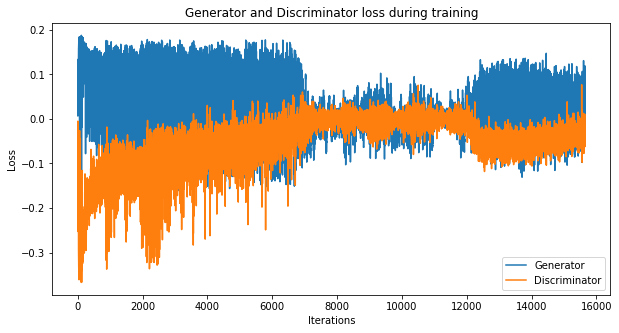

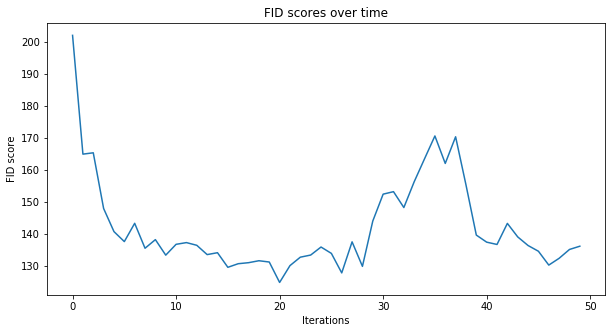

In [4]:
# Number of classes in CIFAR-10 dataset
num_classes = 10

if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = CSAWGenerator(latent_size=latent_size, num_classes=num_classes, hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = CSAWDiscriminator(num_classes=num_classes, hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

fixed_c = t.randint(0, num_classes, (batch_size, 1))
fixed_noise = t.randn(batch_size, latent_size, 1, 1).to(device=device)

# One-hotted fixed label vector
fixed_label = t.zeros(batch_size, num_classes)
fixed_label.scatter_(1, fixed_c.type(t.LongTensor), 1)
fixed_label = fixed_label.view(-1, num_classes, 1, 1).to(device=device)

# Label preprocess
onehot = t.zeros(num_classes, num_classes)
onehot = onehot.scatter_(1, t.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(num_classes, 1), 1).view(num_classes, num_classes, 1, 1)
# Here 32 represents the image dimension
fill = t.zeros([num_classes, num_classes, 32, 32]).to(device=device)
for idx in range(num_classes):
    fill[idx, idx, :, :] = 1

dis_optimizer = toptimizer.RMSprop(discriminator.parameters(), lr=learning_rate)
gen_optimizer = toptimizer.RMSprop(generator.parameters(), lr=learning_rate)

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # DISCRIMINATOR
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        real_labels = data[1].to(device=device)
        # Batch size
        bs = real_images.size(0)

        # Create real, fake, and filled labels
        y_real = t.ones(bs).to(device=device)
        y_fake = t.zeros(bs).to(device=device)
        c_fill = fill[real_labels].to(device=device)

        output = discriminator(real_images, c_fill)
        # Hinge loss
        dis_err_real = output.mean()
        # Discriminator output mean for real images
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        epoch_labels = (t.rand(bs, 1) * num_classes).type(t.LongTensor).squeeze()
        epoch_labels_onehot = onehot[epoch_labels].to(device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise, epoch_labels_onehot)
        # Discriminator output for fake images
        c_fill = fill[epoch_labels].to(device=device)
        output = discriminator(fake_images.detach(), c_fill)
        dis_err_fake = output.mean()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = -(dis_err_real - dis_err_fake)
        discriminator.zero_grad()
        dis_err.backward()
        dis_optimizer.step()

        for param in discriminator.parameters():
            param.data.clamp_(-0.01, 0.01)

        if idx % critic_iters == 0:
            # GENERATOR
            # Train with fake data
            epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
            epoch_labels = (t.rand(bs, 1) * num_classes).type(t.LongTensor).squeeze()
            epoch_labels_onehot = onehot[epoch_labels].to(device=device)
            fake_images = generator(epoch_noise, epoch_labels_onehot)
            # Test discriminator again - this time after training it
            c_fill = fill[epoch_labels].to(device=device)
            output = discriminator(fake_images, c_fill)
            # Hinge loss
            gen_err = - output.mean()
            generator.zero_grad()
            gen_err.backward()
            # Discriminator output mean for fake images - after discriminator update
            D_G_z2 = output.mean().item()
            gen_optimizer.step()

            gen_losses.append(gen_err.item())
            dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 100 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(fixed_noise, fixed_label)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)

        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            fake_images = generator(fixed_noise, fixed_label)
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Save attention map
    tutils.save_image(discriminator.attn_layer.get_attention(as_image=True), "{0}/discriminator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)
    tutils.save_image(generator.attn_layer.get_attention(as_image=True), "{0}/generator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, r_labels = next(testing_data_iter)
            r_im.to(device=device)
            r_labels.to(device=device)
            onehot_r_labels = onehot[r_labels].to(device=device)
            for oh_fixed_label in fixed_label:
                # Find out which real images belong to each fixed label
                indexes = (onehot_r_labels.squeeze() == oh_fixed_label.squeeze()).all(dim=1)
                c_images = r_im[indexes]
                if real_image_batch is None:
                    real_image_batch = c_images
                else:
                    real_image_batch = t.cat((real_image_batch, c_images), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    # We need to perform this truncation to prevent as our while loop above does not do it
    real_image_batch = real_image_batch[:len(fake_image_batch)]
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

In [5]:
from numpy import argmin
if save_best:
    best_gen_weights = gen_filenames[argmin(fid_scores)]
    logging.info("Generator model with lowest FID score is {}".format(best_gen_weights))
    generator.load_state_dict(t.load(best_gen_weights))
    best_fake_image_path = "{0}/best_fake_sample.png".format(output_path)
    logging.info("Saving output of best generator model to {}".format(best_fake_image_path))
    tutils.save_image(generator(fixed_noise, fixed_label).detach(), best_fake_image_path, normalize=True)

21/10/2019 07:02:23 PM - INFO: Generator model with lowest FID score is ./output/csawgan/generator_epoch_21.pth
21/10/2019 07:02:24 PM - INFO: Saving output of best generator model to ./output/csawgan/best_fake_sample.png


21/10/2019 07:02:24 PM - INFO: Last image generated


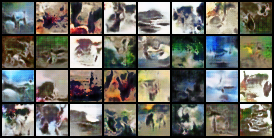

21/10/2019 07:02:24 PM - INFO: Image generated from model with lowest FID score


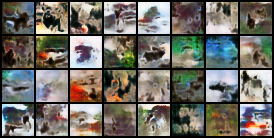

In [6]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))